In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

El método de red neuronal FeedForward para predecir series temporales es un enfoque de aprendizaje automático que utiliza una red neuronal para aprender la relación entre los valores pasados de una serie temporal y los valores futuros.
Una red neuronal FeedForward es un tipo de red neuronal que se caracteriza por el hecho de que las conexiones entre las neuronas solo se producen en una dirección, desde las neuronas de entrada hasta las neuronas de salida.
En el contexto de la predicción de series temporales, una red neuronal FeedForward se puede utilizar para aprender la relación entre los valores pasados de una serie temporal y los valores futuros. Para ello, la red neuronal se entrena con un conjunto de datos de valores pasados y futuros de la serie temporal.
La red neuronal aprende a predecir los valores futuros de la serie temporal utilizando una función de activación. La función de activación es una función matemática que se utiliza para convertir la salida de la red neuronal en un valor predictivo.

In [2]:
df = pd.read_csv("demanda_nacional.csv", index_col=0)

df

,Energia Consumida Mw/h
Fecha,
2011-01-01,605.99
2011-01-02,641.86
2011-01-03,801.30
2011-01-04,833.25
2011-01-05,803.48
...,...
2023-08-17,705.51
2023-08-18,706.09
2023-08-19,664.26


In [3]:
PASOS=10

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
10,0.267810,0.349922,0.714907,0.788046,0.719897,0.389548,0.586828,0.515521,0.429379,0.769366,0.802147
11,0.349922,0.714907,0.788046,0.719897,0.389548,0.586828,0.515521,0.429379,0.769366,0.802147,0.784612
12,0.714907,0.788046,0.719897,0.389548,0.586828,0.515521,0.429379,0.769366,0.802147,0.784612,0.784452
13,0.788046,0.719897,0.389548,0.586828,0.515521,0.429379,0.769366,0.802147,0.784612,0.784452,0.776852
14,0.719897,0.389548,0.586828,0.515521,0.429379,0.769366,0.802147,0.784612,0.784452,0.776852,0.575222


In [4]:
# split into train and test sets
values = reframed.values
n_train_days = 4616 - (223+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(4383, 1, 10) (4383,) (223, 1, 10) (223,)


In [5]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [6]:
EPOCHS=200

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 10)             110       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
439/439 [==============================] - 2s 3ms/step - loss: 0.1220 - mse: 0.0257 - val_loss: 0.0968 - val_mse: 0.0146
Epoch 2/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0719 - mse: 0.0091 - val_loss: 0.0565 - val_mse: 0.0059
Epoch 3/200
439/

Epoch 56/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0429 - mse: 0.0046 - val_loss: 0.0417 - val_mse: 0.0036
Epoch 57/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0433 - mse: 0.0046 - val_loss: 0.0403 - val_mse: 0.0036
Epoch 58/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0434 - mse: 0.0046 - val_loss: 0.0418 - val_mse: 0.0036
Epoch 59/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0431 - mse: 0.0046 - val_loss: 0.0390 - val_mse: 0.0035
Epoch 60/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0431 - mse: 0.0046 - val_loss: 0.0396 - val_mse: 0.0035
Epoch 61/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0435 - mse: 0.0046 - val_loss: 0.0398 - val_mse: 0.0035
Epoch 62/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0431 - mse: 0.0046 - val_loss: 0.0416 - val_mse: 0.0036
Epoch 63/200
439/439 [==============================] - 1s 2ms

439/439 [==============================] - 1s 2ms/step - loss: 0.0423 - mse: 0.0044 - val_loss: 0.0386 - val_mse: 0.0033
Epoch 118/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0417 - mse: 0.0044 - val_loss: 0.0419 - val_mse: 0.0035
Epoch 119/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0044 - val_loss: 0.0383 - val_mse: 0.0033
Epoch 120/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0423 - mse: 0.0044 - val_loss: 0.0403 - val_mse: 0.0034
Epoch 121/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0424 - mse: 0.0044 - val_loss: 0.0400 - val_mse: 0.0034
Epoch 122/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0417 - mse: 0.0044 - val_loss: 0.0384 - val_mse: 0.0033
Epoch 123/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0044 - val_loss: 0.0392 - val_mse: 0.0034
Epoch 124/200
439/439 [==============================] - 1s 2ms/step 

Epoch 178/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0404 - mse: 0.0041 - val_loss: 0.0367 - val_mse: 0.0030
Epoch 179/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0400 - mse: 0.0041 - val_loss: 0.0376 - val_mse: 0.0030
Epoch 180/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0404 - mse: 0.0041 - val_loss: 0.0367 - val_mse: 0.0029
Epoch 181/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0407 - mse: 0.0041 - val_loss: 0.0414 - val_mse: 0.0033
Epoch 182/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0401 - mse: 0.0041 - val_loss: 0.0366 - val_mse: 0.0029
Epoch 183/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0042 - val_loss: 0.0371 - val_mse: 0.0030
Epoch 184/200
439/439 [==============================] - 1s 2ms/step - loss: 0.0402 - mse: 0.0041 - val_loss: 0.0367 - val_mse: 0.0029
Epoch 185/200
439/439 [==============================] 

7/7 [==============================] - 0s 3ms/step
223


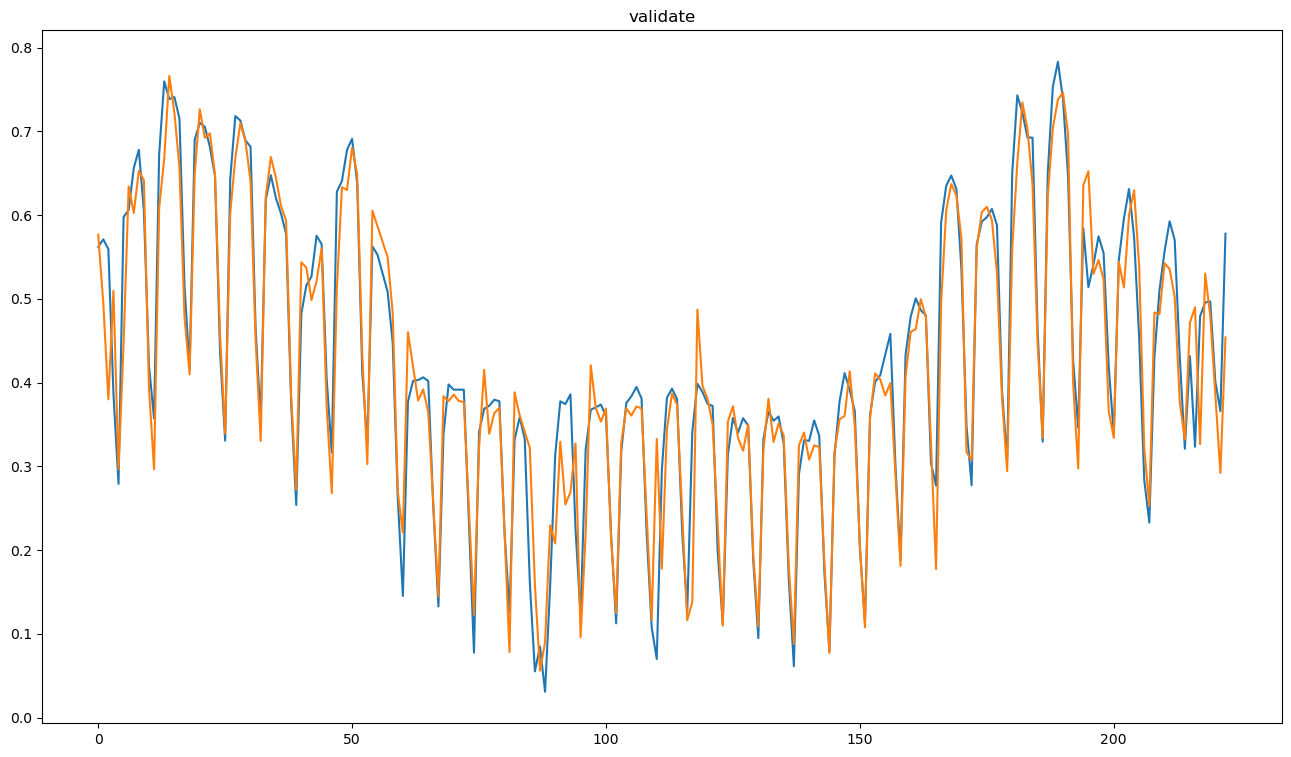

In [7]:
results=model.predict(x_val)
print( len(results) )
plt.plot(range(len(y_val)),y_val)
plt.plot(range(len(results)),results)
plt.title('validate')
plt.show()

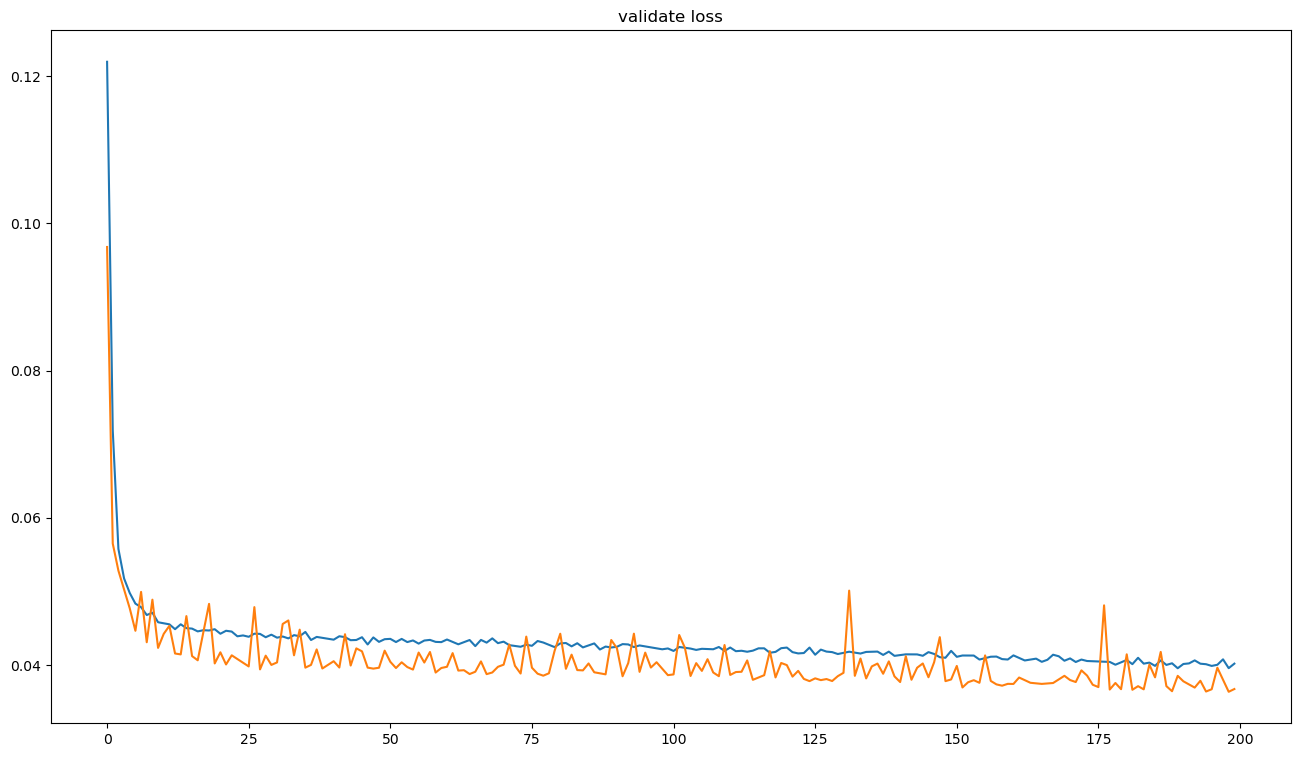

In [8]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [9]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,734.479980,740.902466,-6.422485
1,738.450012,705.174072,33.275940
2,733.390015,654.995178,78.394836
3,657.909973,711.594177,-53.684204
4,610.960022,618.467712,-7.507690


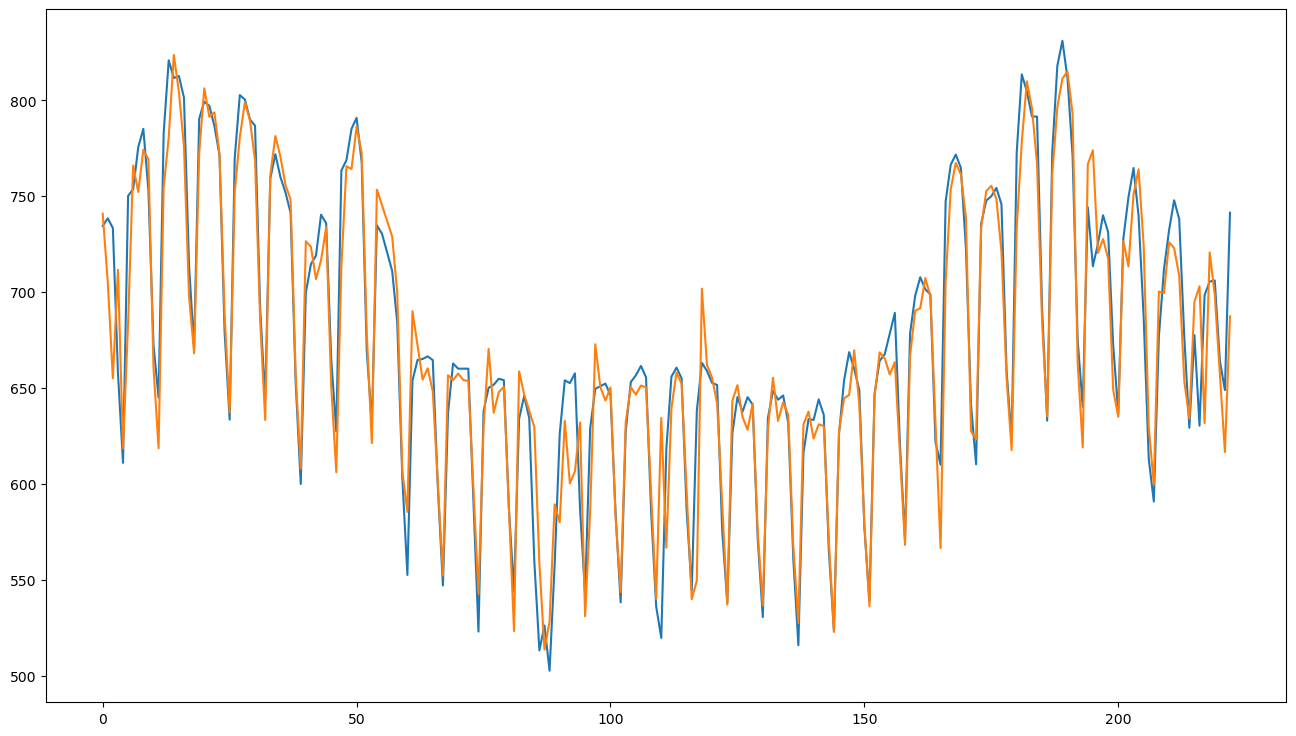

In [10]:
compara2['real'].plot()
compara2['prediccion'].plot()
plt.savefig("comparativa_real_predict_ff.png")
plt.show()

In [11]:
r2 = r2_score(compara2['real'], compara2['prediccion'])
r2

0.9030089110775632

In [12]:
compara2

,real,prediccion,diferencia
0,734.479980,740.902466,-6.422485
1,738.450012,705.174072,33.275940
2,733.390015,654.995178,78.394836
3,657.909973,711.594177,-53.684204
4,610.960022,618.467712,-7.507690
...,...,...,...
218,705.510010,720.679382,-15.169373
219,706.090027,698.542053,7.547974
220,664.260010,658.077942,6.182068
221,648.869995,616.603943,32.266052


In [13]:
ultimosDias = df[-460:-233]
ultimosDias

,Energia Consumida Mw/h
Fecha,
2022-05-19,716.67
2022-05-20,714.90
2022-05-21,645.69
2022-05-22,591.02
2022-05-23,692.29
...,...
2022-12-27,611.57
2022-12-28,629.53
2022-12-29,636.82


In [14]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-2),var1(t-1),var1(t)
10,0.654751,0.649661,0.450621,0.293397,0.584637,0.605343,0.558495,0.581416,0.401875,0.260267
11,0.649661,0.450621,0.293397,0.584637,0.605343,0.558495,0.574945,0.401875,0.260267,0.526573
12,0.450621,0.293397,0.584637,0.605343,0.558495,0.574945,0.581416,0.260267,0.526573,0.606494
13,0.293397,0.584637,0.605343,0.558495,0.574945,0.581416,0.401875,0.526573,0.606494,0.634591
14,0.584637,0.605343,0.558495,0.574945,0.581416,0.401875,0.260267,0.606494,0.634591,0.647360
15,0.605343,0.558495,0.574945,0.581416,0.401875,0.260267,0.526573,0.634591,0.647360,0.639768
16,0.558495,0.574945,0.581416,0.401875,0.260267,0.526573,0.606494,0.647360,0.639768,0.413407


In [15]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(211, 1, 10)


array([[[0.5584954 , 0.57494533, 0.581416  , ..., 0.64735997,
         0.63976777, 0.41340733]],

       [[0.57494533, 0.581416  , 0.40187502, ..., 0.63976777,
         0.41340733, 0.27228808]],

       [[0.581416  , 0.40187502, 0.2602669 , ..., 0.41340733,
         0.27228808, 0.5253941 ]],

       ...,

       [[0.6339873 , 0.6757735 , 0.63832986, ..., 0.35249627,
         0.40414715, 0.42511225]],

       [[0.6757735 , 0.63832986, 0.59119415, ..., 0.40414715,
         0.42511225, 0.3871218 ]],

       [[0.63832986, 0.59119415, 0.48541927, ..., 0.42511225,
         0.3871218 , 0.202088  ]]], dtype=float32)

In [16]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [17]:
results=[]
for i in range(233):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

7/7 [==============================] - 0s 2ms/step
[[[0.5584954  0.57494533 0.581416   ... 0.64735997 0.63976777 0.41340733]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 3ms/step
[[[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.22398739]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 3ms/step
[[[0.45361924 0.2245945  0.2627688  ... 0.49313116 0.2313087  0.30736095]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 3ms/step
[[[0.2245945  0.2627688  0.5594854  ... 0.2313087  0.30736095 0.5838163 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 2ms/step
[[[0.33683276 0.5973357  0.61058843 ... 0.36041343 0.6055028  0.6179693 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 3ms/step
[[[0.5973357  0.61058843 0.63233995 ... 0.6055028  0.6179693  0.6335168 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 2ms/step
[[[0.6246603  0.6361427  0.6560369  ... 0.6324059  0.6411615  0.6612399 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 3ms/step
[[[0.6361427  0.6560369  0.49576882 ... 0.6411615  0.6612399  0.48194233]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 3ms/step
[[[0.6693186  0.4635824  0.13226284 ... 0.6809328  0.4384227  0.09358635]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 1ms/step
[[[0.4635824  0.13226284 0.48288912 ... 0.4384227  0.09358635 0.531968  ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 0s/step
[[[ 0.04019972  0.59227425  0.6814737  ... -0.03288129  0.6640927
    0.70978546]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 ...  0.40414715  0.42511225
    0.3871218 ]]

 [[ 0.63832986  0.59119415  0.48541927 ...  0.42511225  0.3871218
    0.202088  ]]]
7/7 [==============================] - 0s 3ms/step
[[[0.59227425 0.6814737  0.70808446 ... 0.6640927  0.70978546 0.74111056]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]


7/7 [==============================] - 0s 362us/step
[[[0.73869705 0.77093494 0.75269264 ... 0.7635835  0.7906553  0.7685186 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 0s/step
[[[0.77093494 0.75269264 0.7300415  ... 0.7906553  0.7685186  0.7090804 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.4251122

7/7 [==============================] - 0s 2ms/step
[[[ 0.7820813   0.6598612  -0.12662898 ...  0.7972855   0.5890155
   -0.17442468]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 ...  0.40414715  0.42511225
    0.3871218 ]]

 [[ 0.63832986  0.59119415  0.48541927 ...  0.42511225  0.3871218
    0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[ 0.6598612  -0.12662898 -0.20568302 ...  0.5890155  -0.17442468
   -0.08855393]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415

7/7 [==============================] - 0s 2ms/step
[[[0.66735715 0.7822527  0.78844154 ... 0.81855243 0.7865124  0.794401  ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[0.7822527  0.78844154 0.80682653 ... 0.7865124  0.794401   0.79378355]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 2ms/step
[[[0.8032187  0.79434896 0.6441341  ... 0.8164563  0.80617815 0.5545079 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[ 0.79434896  0.6441341  -0.17921126 ...  0.80617815  0.5545079
   -0.19942206]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 ...  0.40414715  0.42511225
    0.3871218 ]]

 [[ 0.

7/7 [==============================] - 0s 2ms/step
[[[ 0.45873612 -0.18873583  0.22165294 ...  0.33850497 -0.18206012
    0.52225965]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 ...  0.40414715  0.42511225
    0.3871218 ]]

 [[ 0.63832986  0.59119415  0.48541927 ...  0.42511225  0.3871218
    0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[-0.18873583  0.22165294  0.83474106 ... -0.18206012  0.52225965
    0.7913175 ]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.5911941

7/7 [==============================] - 0s 2ms/step
[[[0.7491876  0.78308046 0.79060906 ... 0.85169494 0.79203445 0.7982768 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[0.78308046 0.79060906 0.8008197  ... 0.79203445 0.7982768  0.7930876 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225

7/7 [==============================] - 0s 2ms/step
[[[0.80897236 0.79935515 0.6029817  ... 0.824027   0.8135326  0.5108285 ]]

 [[0.57494533 0.581416   0.40187502 ... 0.63976777 0.41340733 0.27228808]]

 [[0.581416   0.40187502 0.2602669  ... 0.41340733 0.27228808 0.5253941 ]]

 ...

 [[0.6339873  0.6757735  0.63832986 ... 0.35249627 0.40414715 0.42511225]]

 [[0.6757735  0.63832986 0.59119415 ... 0.40414715 0.42511225 0.3871218 ]]

 [[0.63832986 0.59119415 0.48541927 ... 0.42511225 0.3871218  0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[ 0.79935515  0.6029817  -0.19501777 ...  0.8135326   0.5108285
   -0.19655387]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 ...  0.40414715  0.42511225
    0.3871218 ]]

 [[ 0.

7/7 [==============================] - 0s 2ms/step
[[[ 0.40600988 -0.18329027  0.36546895 ...  0.26527864 -0.19215006
    0.647227  ]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 ...  0.40414715  0.42511225
    0.3871218 ]]

 [[ 0.63832986  0.59119415  0.48541927 ...  0.42511225  0.3871218
    0.202088  ]]]
7/7 [==============================] - 0s 2ms/step
[[[-0.18329027  0.36546895  0.8112225  ... -0.19215006  0.647227
    0.7833152 ]]

 [[ 0.57494533  0.581416    0.40187502 ...  0.63976777  0.41340733
    0.27228808]]

 [[ 0.581416    0.40187502  0.2602669  ...  0.41340733  0.27228808
    0.5253941 ]]

 ...

 [[ 0.6339873   0.6757735   0.63832986 ...  0.35249627  0.40414715
    0.42511225]]

 [[ 0.6757735   0.63832986  0.59119415 

In [18]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)


In [19]:
inverted

array([[566.88488794],
       [558.37821066],
       [669.0997585 ],
       [686.99358336],
       [702.57317367],
       [706.60567453],
       [646.73247225],
       [567.095995  ],
       [580.3699623 ],
       [683.54424226],
       [692.76256843],
       [706.74911727],
       [712.42208005],
       [660.47155592],
       [569.43065476],
       [595.87554104],
       [692.00458719],
       [697.80497173],
       [708.41227387],
       [714.72835593],
       [666.00986366],
       [568.06145631],
       [606.12347983],
       [696.70555488],
       [701.31379567],
       [708.87723481],
       [715.48816104],
       [666.73638326],
       [564.38155187],
       [614.32295004],
       [699.54541456],
       [703.8802623 ],
       [709.28644354],
       [716.07316537],
       [664.86093305],
       [559.26085714],
       [622.49673072],
       [701.77772031],
       [706.20687011],
       [710.19951539],
       [717.11714091],
       [661.38872111],
       [552.9099766 ],
       [631

In [20]:
prediccion2023 = df.tail(233)
prediccion2023["predicción"]=inverted.flatten().tolist()
prediccion2023.rename(columns={"Energia Consumida Mw/h": "real"}, inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_6420\4272489419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediccion2023["predicción"]=inverted.flatten().tolist()
C:\Users\PC\AppData\Local\Temp\ipykernel_6420\4272489419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediccion2023.rename(columns={"Energia Consumida Mw/h": "real"}, inplace=True)


In [21]:
prediccion2023

,real,predicción
Fecha,,
2023-01-01,501.61,566.884888
2023-01-02,617.39,558.378211
2023-01-03,672.48,669.099759
2023-01-04,685.39,686.993583
2023-01-05,666.70,702.573174
...,...,...
2023-08-17,705.51,406.487853
2023-08-18,706.09,771.057501
2023-08-19,664.26,762.499206


In [22]:
prediccion2023.index = pd.to_datetime(prediccion2023.index)

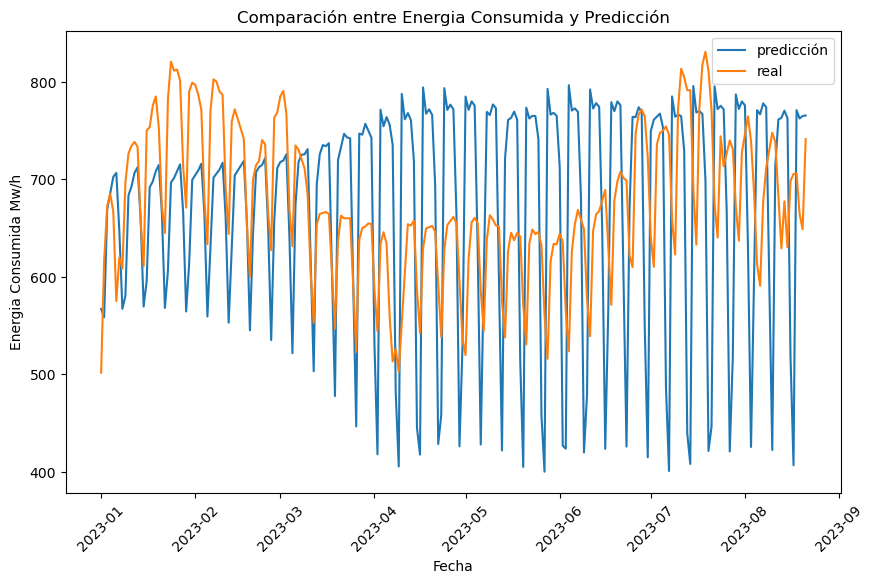

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(prediccion2023.index, prediccion2023['predicción'], label='predicción')
plt.plot(prediccion2023.index, prediccion2023['real'], label='real')
plt.xlabel('Fecha')
plt.ylabel('Energia Consumida Mw/h')
plt.title('Comparación entre Energia Consumida y Predicción')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [24]:
r2 = r2_score(prediccion2023['predicción'], prediccion2023['real'])
r2

-0.23765150105314903

In [26]:
prediccion2023['predicción']

array([566.88488794, 558.37821066, 669.0997585 , 686.99358336,
       702.57317367, 706.60567453, 646.73247225, 567.095995  ,
       580.3699623 , 683.54424226, 692.76256843, 706.74911727,
       712.42208005, 660.47155592, 569.43065476, 595.87554104,
       692.00458719, 697.80497173, 708.41227387, 714.72835593,
       666.00986366, 568.06145631, 606.12347983, 696.70555488,
       701.31379567, 708.87723481, 715.48816104, 666.73638326,
       564.38155187, 614.32295004, 699.54541456, 703.8802623 ,
       709.28644354, 716.07316537, 664.86093305, 559.26085714,
       622.49673072, 701.77772031, 706.20687011, 710.19951539,
       717.11714091, 661.38872111, 552.9099766 , 631.82886185,
       704.18186306, 708.90015746, 711.94466296, 718.92633097,
       656.58097448, 545.05256894, 643.08630929, 707.31472233,
       712.54487998, 714.85525955, 721.73545441, 650.19686023,
       534.99043111, 656.91019227, 711.6865655 , 717.78432275,
       719.34675232, 725.77394499, 641.44833445, 521.54

In [27]:
prediccion2023['predicción'].to_csv('demanda_nacional_FF.csv', index=False)